In [62]:
%matplotlib inline
%load_ext cython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from plotting_utils import label_sample, figure_path
import pandas as pd
import glob
import re
import os
from multiprocessing import Pool
import seaborn as sns
from matplotlib import rcParams
from sequencing_tools.viz_tools import color_encoder, okabeito_palette
from sklearn.preprocessing import LabelEncoder
from Bio import SeqUtils

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
%%cython
from collections import Counter, defaultdict
from operator import itemgetter
import re
from xopen import xopen

sc_re = re.compile('([0-9]+)S')
cdef soft_clip_base(cigar):
    s = sc_re.findall(cigar)
    s = map(int, s)
    return sum(s)

cpdef get_start(sample_folder):
    cdef:
        str line
        str chrom, start, end, strand, cigar
        list fields
        int sstart, send
    
    tRNA_regex = re.compile('^TR[A-Z]-|^MT')
    end_loc_counter = defaultdict(Counter)
    bed_file = sample_folder + '/count_temp/small_RNA.bed.gz'
    with xopen(bed_file) as bed:
        for line in bed:
            fields = line.strip().split('\t')
            chrom, start, end, strand, cigar = itemgetter(0,1,2,5, 6)(fields)
            sstart, send = int(start), int(end)
            
            is_tRNA = tRNA_regex.search(chrom)
            is_sense = strand == "+"
            good_alignment = soft_clip_base(cigar) < 10 
            not_fulllength = (send - sstart) < 50
            if is_tRNA and is_sense and good_alignment and not_fulllength:
                end_loc_counter[long(start)][long(end)] += 1
    return end_loc_counter

In [22]:
sample_folders = glob.glob('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/*001')
sample_folders = filter(lambda x: re.search('^[Qq][cC][fF][0-9]+|[qQ][cC][fF]_[pP]hos|[DE][ED]|Exo|[fF]rag|GC', os.path.basename(x)), 
                     sample_folders) 
sample_folders = list(sample_folders)

In [87]:
df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/tsRNA.feather') \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(is_mt = lambda d: np.where(d.tRNA.str.startswith('MT'),'MT-',''))\
    .groupby(['anticodon','prep','samplename','frag_type','aa','is_mt'], as_index=False) \
    .agg({'frag_count':'sum'}) \
    .assign(frag_fraction = lambda d: 100*d.groupby(['samplename','prep','aa','anticodon','is_mt']).frag_count.transform(lambda x: x/x.sum()))\
    .query('frag_type != "Others"')  \
    .assign(anticodon = lambda d: d.is_mt + d.aa +'-'+ d.anticodon) \
    .sort_values(['is_mt','aa']) \
    .assign(frag_type = lambda d: d.frag_type.str.replace('half','tRNA-half'))
df.head()

,anticodon,prep,samplename,frag_type,aa,is_mt,frag_count,frag_fraction
860,Ala-AGC,DNase I,QCF1_R1_001,3' tRNA-half,Ala,,28009,65.226706
861,Ala-AGC,DNase I,QCF1_R1_001,3' tsRNA,Ala,,246,0.572879
862,Ala-AGC,DNase I,QCF1_R1_001,5' tRNA-half,Ala,,12,0.027945
863,Ala-AGC,DNase I,QCF1_R1_001,Full-length,Ala,,12646,29.449710
865,Ala-AGC,DNase I,QCF2_R1_001,3' tRNA-half,Ala,,42996,60.516834


In [92]:
df.prep.unique()

array(['DNase I', 'DNase I + Exo I', "DNase I - 3'P", 'EV', 'Fragmented',
       'HEK293', 'High salt (450mM)', 'MNase EV', 'MNase EV+RNP',
       'MNase RNP', 'NaOH', 'RNP', 'RNP+EV', 'Untreated'], dtype=object)

In [99]:
prep = ['DNase I', "DNase I - 3'P"]#, 'MNase RNP','MNase EV']#,"HEK293"]
tsRNA = ['Full-length',"3' tRNA-half", "5' tRNA-half", "3' tsRNA"]
anticodon = df.anticodon.unique().tolist()

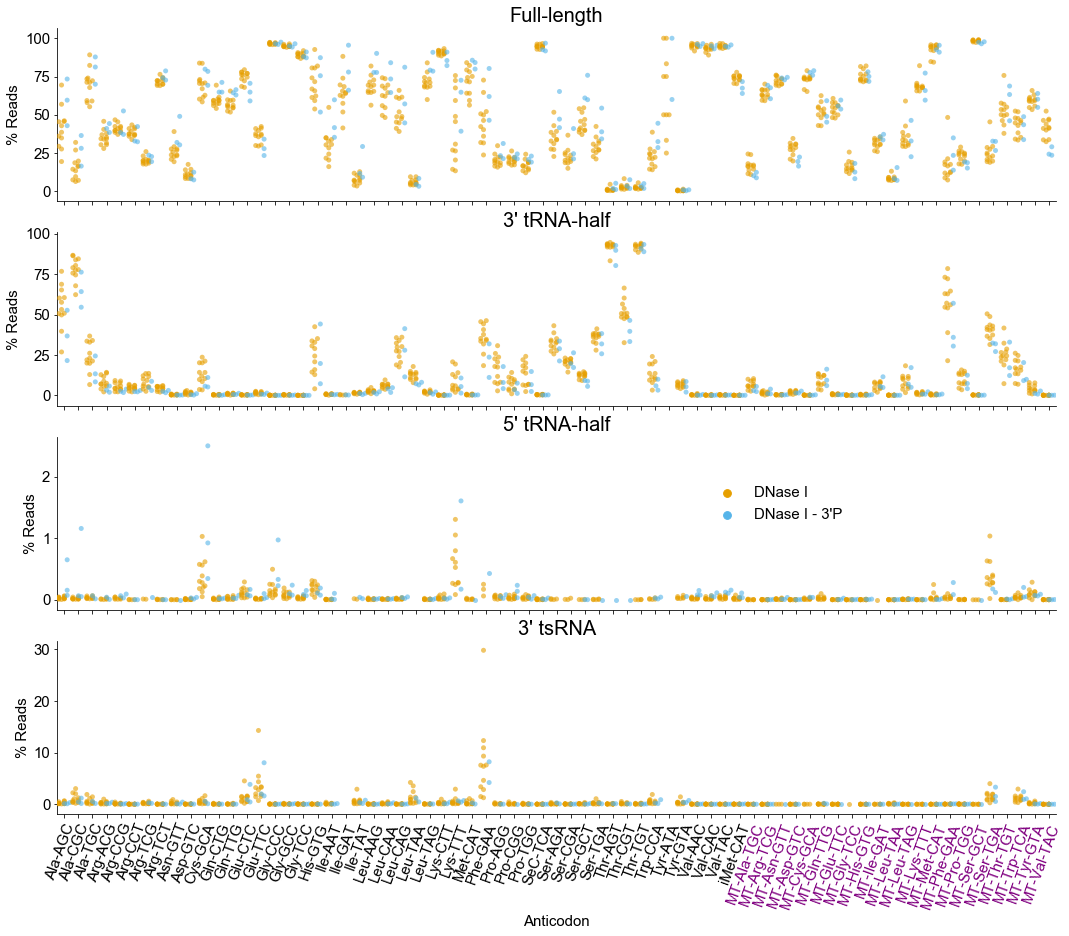

In [100]:
p = sns.FacetGrid(data = df.pipe(lambda d: d[d.prep.isin(prep)]), 
                col = 'frag_type', 
                col_wrap=1, 
                col_order = tsRNA,
                aspect=5,
                sharey=False)
p.map(sns.swarmplot,
      'anticodon',
      'frag_fraction',
      'prep',
      alpha=0.6,
      hue_order = prep,
      order = anticodon,
      dodge=True,
      palette = okabeito_palette())#['#85a9e2','#f7cd62','red'])
for ax in p.fig.axes:
    ax.set_xticklabels(ax.get_xticklabels(),
                      rotation=70,
                      ha = 'right',
                      rotation_mode='anchor')
    for xt in ax.get_xticklabels():
        if xt.get_text().startswith('MT'):
            xt.set_color('purple')
p.set_titles('{col_name}', size=20)
p.add_legend(fontsize=15, bbox_to_anchor=(0.7,0.5))
p.set_axis_labels('Anticodon', '% Reads')
p.savefig(figure_path + '/tRNA_fragment_percentage.pdf', bbox_inches='tight')

In [14]:
df.query('frag_type == "Full-length" & prep == "DNase I" & aa == "Thr" & is_mt == ""') \
    .groupby('prep')\
    .agg({'frag_fraction':['min','max','mean']})

frag_fraction                    
                  min       max      mean
prep                                     
DNase I      0.452013  8.300527  2.277695

In [65]:
pair_df = df\
    .groupby(['aa','samplename','is_mt','prep'],as_index=False)\
    .agg({'frag_count':'sum'}) \
    .assign(is_mt = lambda d: np.where(d.is_mt.str.contains('MT'),'MT','Nucleo')) \
    .assign(frag_fraction = lambda d: d.groupby(['samplename','is_mt']).frag_count.transform(lambda x: 1e6*x/x.sum()))\
    .assign(log_cpm = lambda d: d.frag_fraction.transform(lambda x: np.log(x+1)))\
    .pipe(pd.pivot_table, columns = 'is_mt', values = 'log_cpm', index=['aa','samplename','prep'],
         fill_value = 0) \
    .reset_index()
pair_df.head()

is_mt,aa,samplename,prep,MT,Nucleo
0,Ala,QCF1_R1_001,DNase I,9.695459,9.471045
1,Ala,QCF2_R1_001,DNase I,9.144696,9.445675
2,Ala,Qcf10_R1_001,DNase I,9.825112,8.854026
3,Ala,Qcf11_R1_001,DNase I,10.791446,8.259450
4,Ala,Qcf12_R1_001,DNase I,10.195690,8.940723


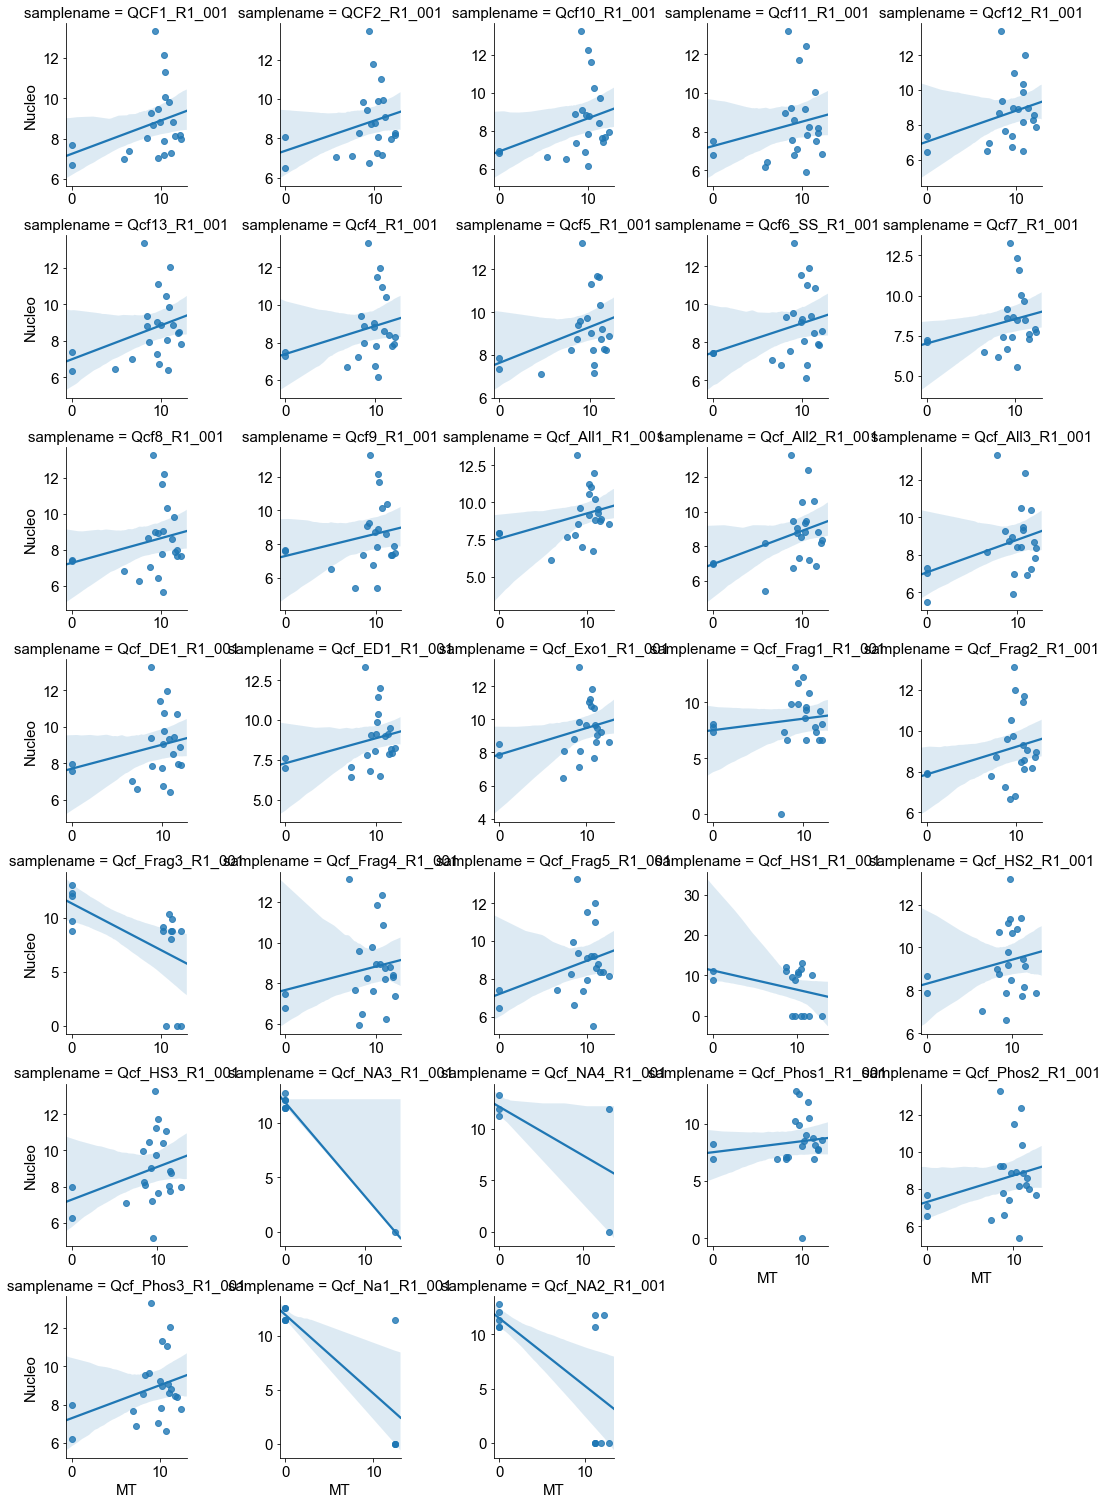

In [66]:
p = sns.FacetGrid(data=pair_df, col='samplename', col_wrap=5,sharex=False, sharey=False)
p.map(sns.regplot, 'MT','Nucleo')